<hr>
<h3>ALLLife Bank Credit Card Customer Segmentation</h3>
<hr>

<b>Background</b>: AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

<b>Data Description</b>: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre. 

<b>Key Questions:</b> 
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

### Importing the Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np 

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet

In [3]:
#Reading the dataset 

df=pd.read_excel('Credit Card Customer Data.xlsx')
df.shape

(660, 7)

In [4]:
#Viewing top 2 rows 

df.head(2)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9


In [10]:
# Dropping duplicates based on unique customer key

df = df.iloc[df['Customer Key'].drop_duplicates(keep='last').index]
df.shape

(655, 7)

#### Additional (Another method to drop duplicated)

Note: Do not run the above cell in order to see the result of this method.

In [5]:
# Dropping duplicates based on latest visit i.e. keeping the entry where avg credit limit is more
# assuming credit limit would increase if a person stays with the bank for more duration

z = df[df['Customer Key'].isin(list(df[df['Customer Key'].duplicated()]['Customer Key']))].sort_values(by='Customer Key')
# slicing all the duplicate values

z['rank1'] = z.groupby(['Customer Key'])['Avg_Credit_Limit'].rank(method='dense',ascending=False)
# Giving rank based on avg_credit_limit, highest value gets rank 1

z = z[z['rank1']==1].drop('rank1',axis=1)
# Selecting all rank 1 values and dropping the rank column

print(z.shape)
print()

df = df.drop(df[df['Customer Key'].isin(list(df[df['Customer Key'].duplicated()]['Customer Key']))].index)
# dropping all the data points which contains duplicate customer key

df =df.append(z)
# Appending the higher credit limit values of duplicate customer key

print(df.shape)

(5, 7)

(655, 7)


The cols : Sl_No and CustomerKey are IDs which can be eliminated as they are unique and will not have any relevant role in forming the clusters so we remove them

In [6]:
cols_to_consider=['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

In [7]:
subset=df[cols_to_consider]  #Selecting only the above columns 

### EDA 

#### Checking for Missing Values 

In [8]:
subset.isna().sum() 

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No missing values were found 

#### Checking for the statistically summary 

In [9]:
subset.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,655.000000,655.000000,655.000000,655.000000,655.000000
mean,34690.076336,4.709924,2.400000,2.618321,3.580153
std,37728.591465,2.171150,1.627929,2.942512,2.852528
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48500.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


The min and max value of 'Avg_Credit_Limit' is very larger as compared to the other columns 
To bring the data to the same scale let's standardize the data.



#### Standard Scaler ( Z Score )

In [10]:
scaler=StandardScaler()
subset_scaled=scaler.fit_transform(subset)   

In [11]:
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)   #Creating a dataframe of the above results

### Data Visualizations 

#### HeatMap :  To check for correlated features 

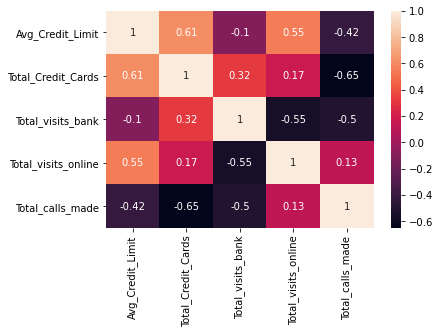

In [12]:
sns.heatmap(subset_scaled_df.corr(),annot=True)
plt.show()

There is no significant correlation observed among the different features 

#### PairPlots

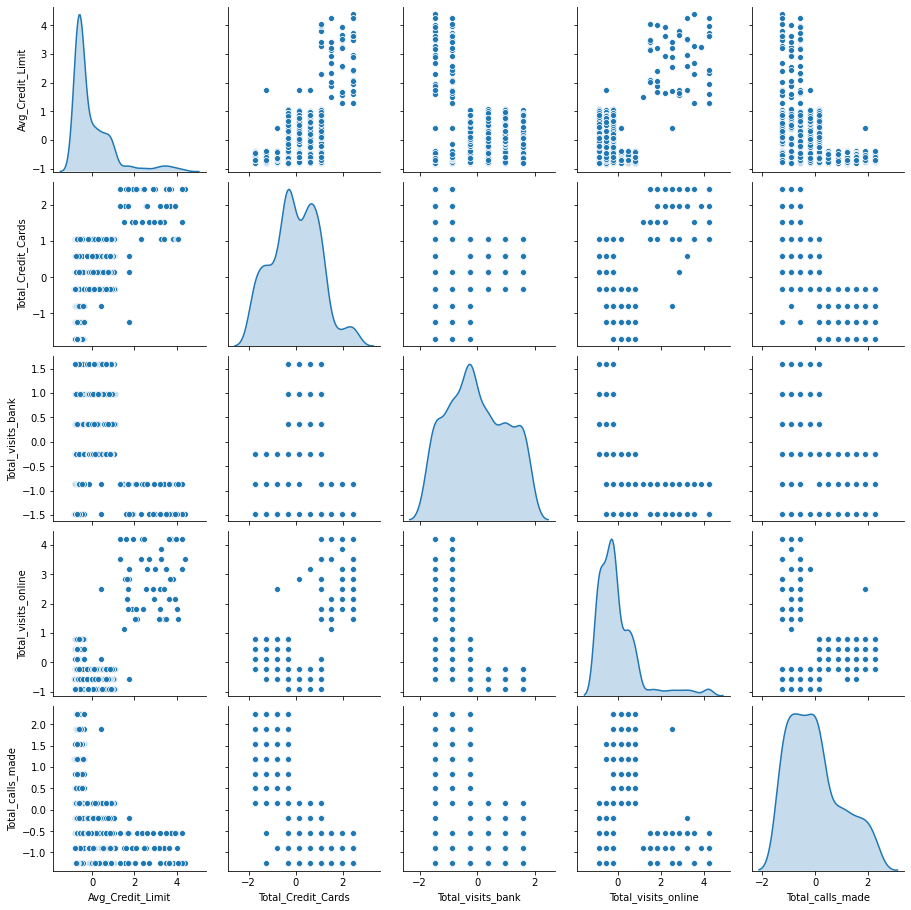

In [13]:
sns.pairplot(subset_scaled_df,diag_kind="kde")

Looking at the diagonal of the pairplot we can assume the data to be a mixture of gaussians , looing at the peaks of the gaussians we can say that the optimal number might come between 2-3 , but to be sure , let's make an elbow  plot




#### Elbow Plot

1 2.006907475615049
2 1.4584982297531062
3 1.1464434305790148
4 1.0459996881068547
5 0.9899515018569832
6 0.9423637009881478
7 0.9109210917763398
8 0.8906561999627348
9 0.8655046018584363


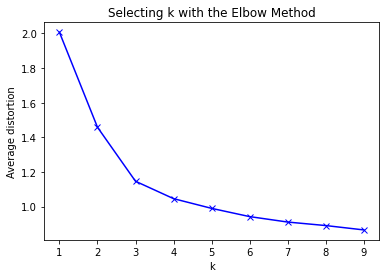

In [14]:

clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print(k,distortion)
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

Looking at the elbow method we can take K=3 , so let's apply Kmeans with k=3 


In [15]:

kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)
kmeans.fit(subset_scaled_df)


KMeans(n_clusters=3, n_init=15, random_state=2345)

In [16]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.59708296, -1.06223867, -0.8994134 ,  0.32284397,  1.14764832],
       [ 2.82096934,  1.85761293, -1.10654432,  2.8166435 , -0.87713902],
       [-0.0221829 ,  0.37320193,  0.66578849, -0.55483952, -0.55070751]])

In [17]:
centroid_df = pd.DataFrame(centroids, columns = subset_scaled_df.columns )

In [18]:
centroid_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.597083,-1.062239,-0.899413,0.322844,1.147648
1,2.820969,1.857613,-1.106544,2.816644,-0.877139
2,-0.022183,0.373202,0.665788,-0.554840,-0.550708


The above are the centroids for the different clusters 

#### Adding Label to the dataset

In [19]:
dataset=subset_scaled_df[:]  #creating a copy of the data 

In [20]:
dataset['KmeansLabel']=kmeans.labels_

In [21]:
dataset.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KmeansLabel
0,1.732369,-1.249105,-0.860646,-0.550400,-1.256040,2
1,0.406101,-0.788168,-1.475392,2.510549,1.901468,0
2,0.406101,1.055582,-0.860646,0.129811,0.147297,2
3,-0.124406,0.133707,-0.860646,-0.550400,0.147297,2
4,-0.389659,-0.788168,-1.475392,-0.550400,1.550634,0
5,1.732369,0.133707,-1.475392,2.850654,-0.554372,1
6,-0.522286,-0.788168,-1.475392,-0.550400,-0.905206,0
7,-0.787540,-1.249105,-1.475392,-0.210294,-0.554372,0
8,-0.840590,-0.327230,-1.475392,-0.550400,1.199799,0
9,-0.654913,-0.327230,-1.475392,0.810022,0.498131,0


### Visualizing the clusters

#### Since the number of dimensions is 5 in the dataset , it is not possible to create 5-d Visualization so we can take any 2 random features and make a scatter plot observing the different  clusters 

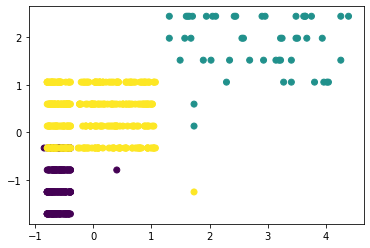

In [22]:


plt.scatter(dataset['Avg_Credit_Limit'], dataset['Total_Credit_Cards'], c=kmeans.labels_,)  
plt.show()

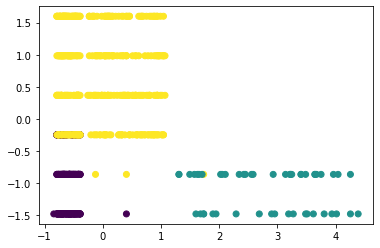

In [23]:
plt.scatter(dataset['Avg_Credit_Limit'], dataset['Total_visits_bank'], c=kmeans.labels_,)  
plt.show()

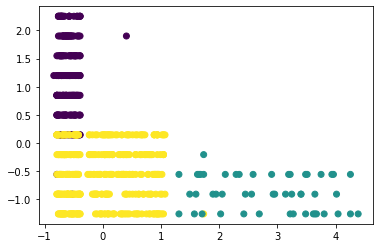

In [24]:
plt.scatter(dataset['Avg_Credit_Limit'], dataset['Total_calls_made'], c=kmeans.labels_,)  
plt.show()

### The clusters we are visualizing seems to do a good job but the preferred way will be to reduce the dimensions to 3 or less (if possible )  and then try to plot the clusters
HINT: Try PCA before clustering 

### Analyse the Clusters 

Let us make a visualization to observe the different clusters by making boxplots , 
for the clusters we expect to observe statistical properties which differentiates clusters with each other 

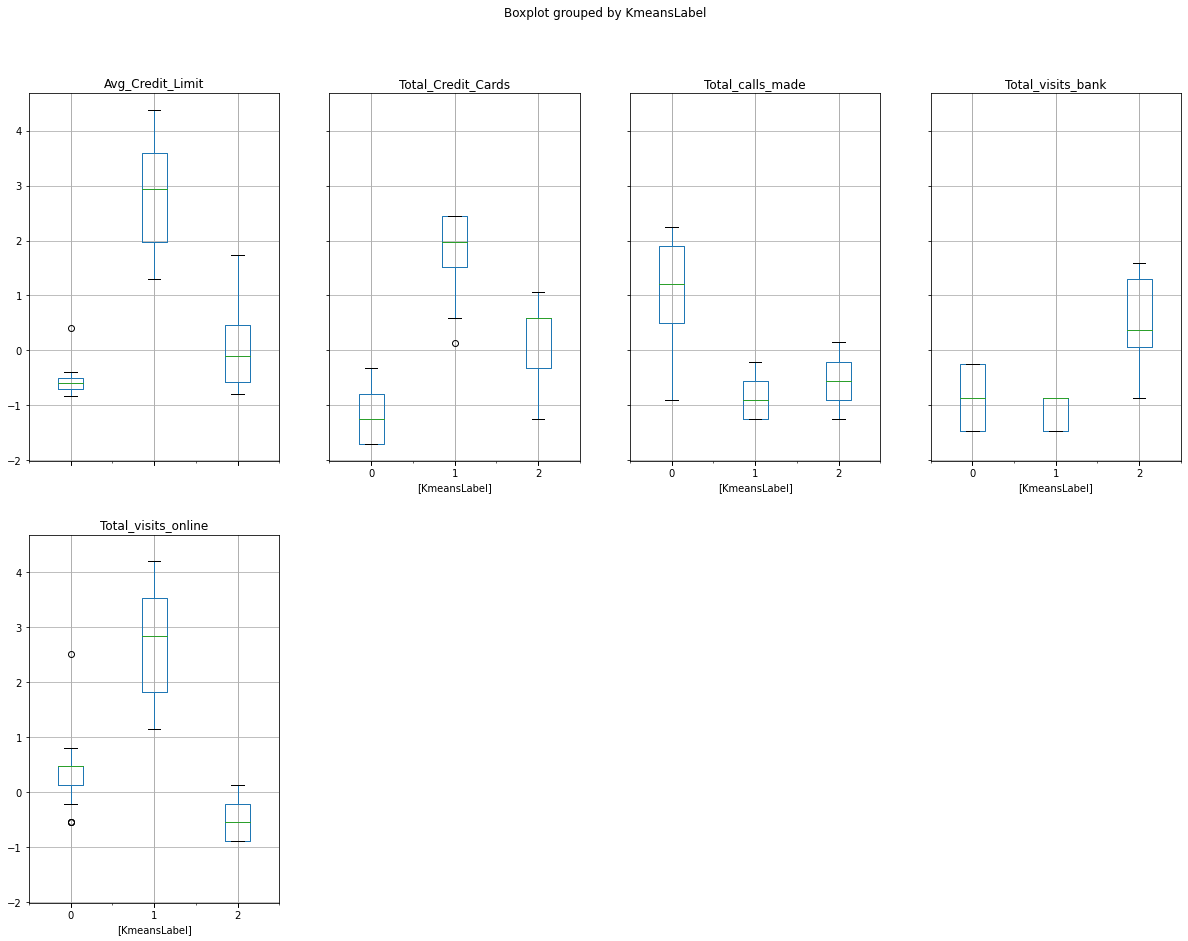

In [25]:
dataset.boxplot(by = 'KmeansLabel',  layout=(2,4), figsize=(20, 15))
plt.show()

Looking the box plot we can observe differentiated clusters 

# Hierarchical Clustering 

Now that we have tried Kmeans , let's try hierarchical clustering with different dendograms for the same dataset and choosing the best using the cophenetic coefficient by using different types of linkages

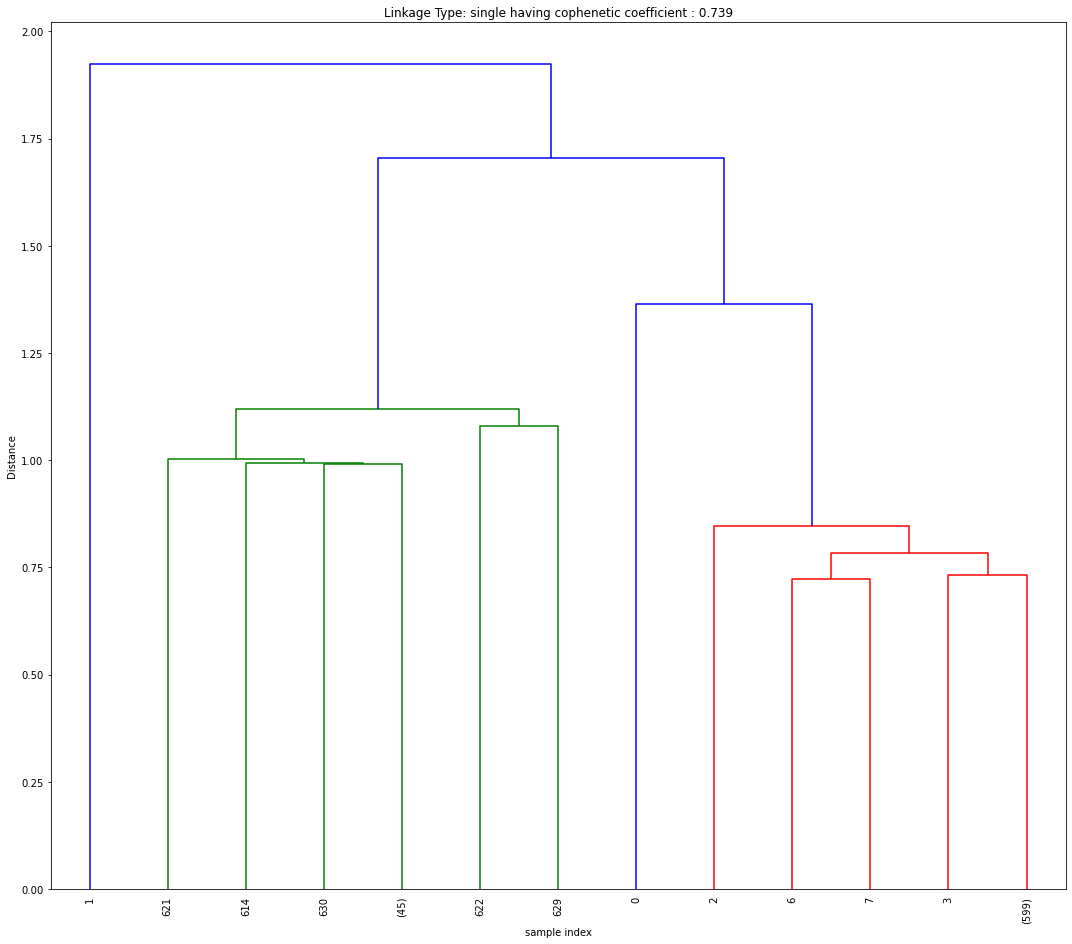

single 0.7391473713405816


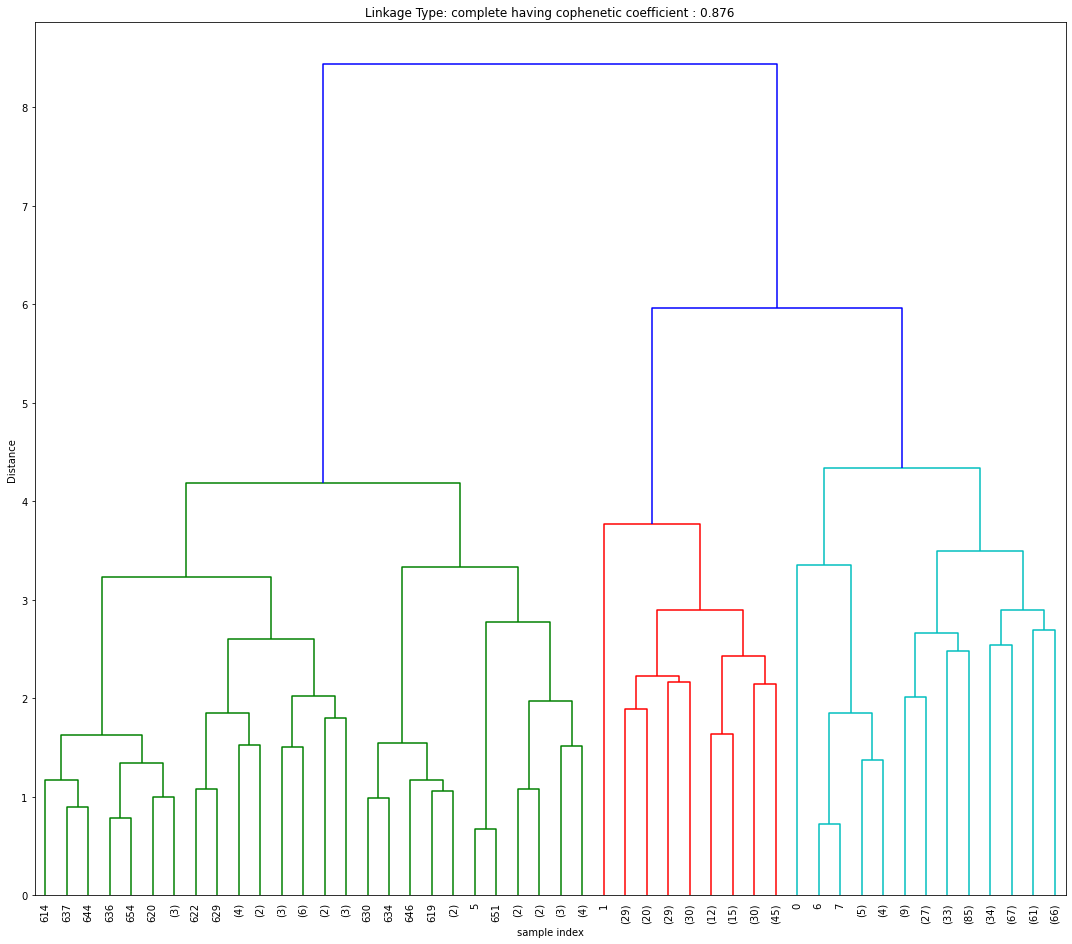

complete 0.8760520584156051


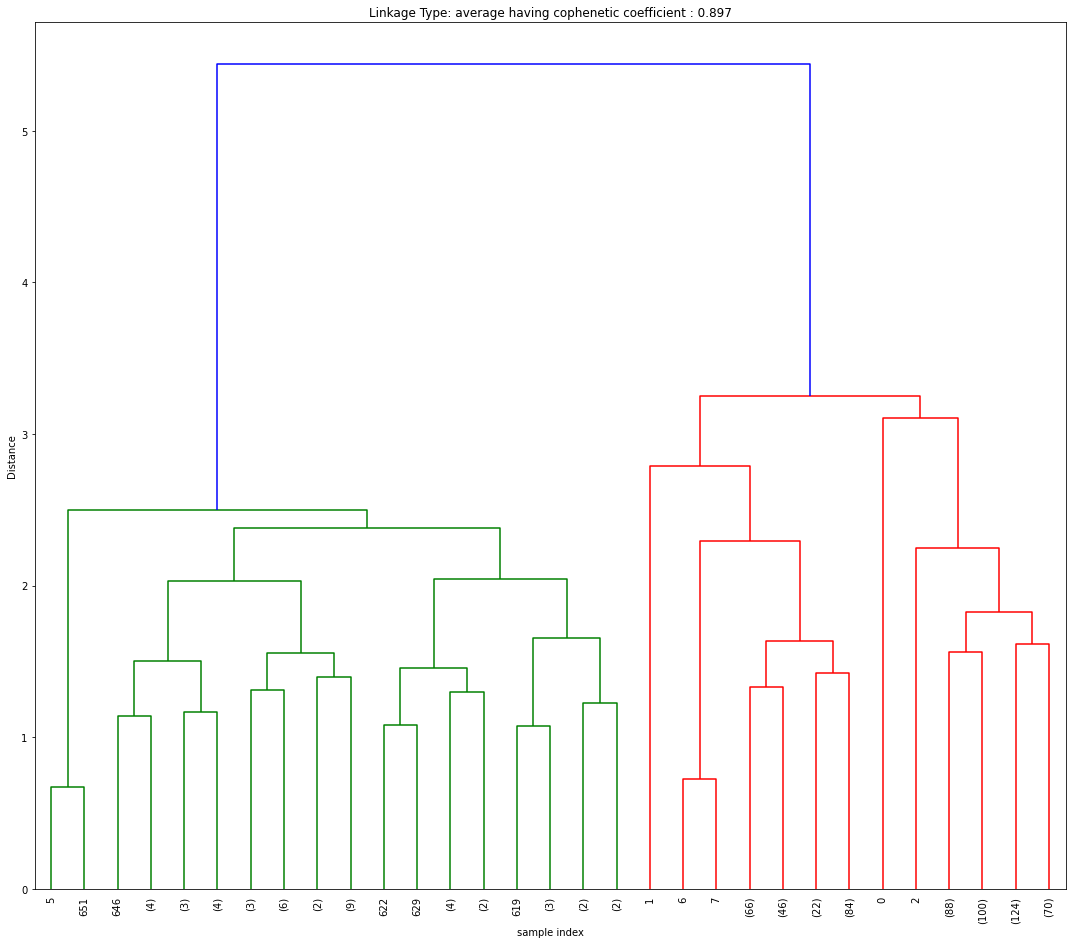

average 0.8974913650544313


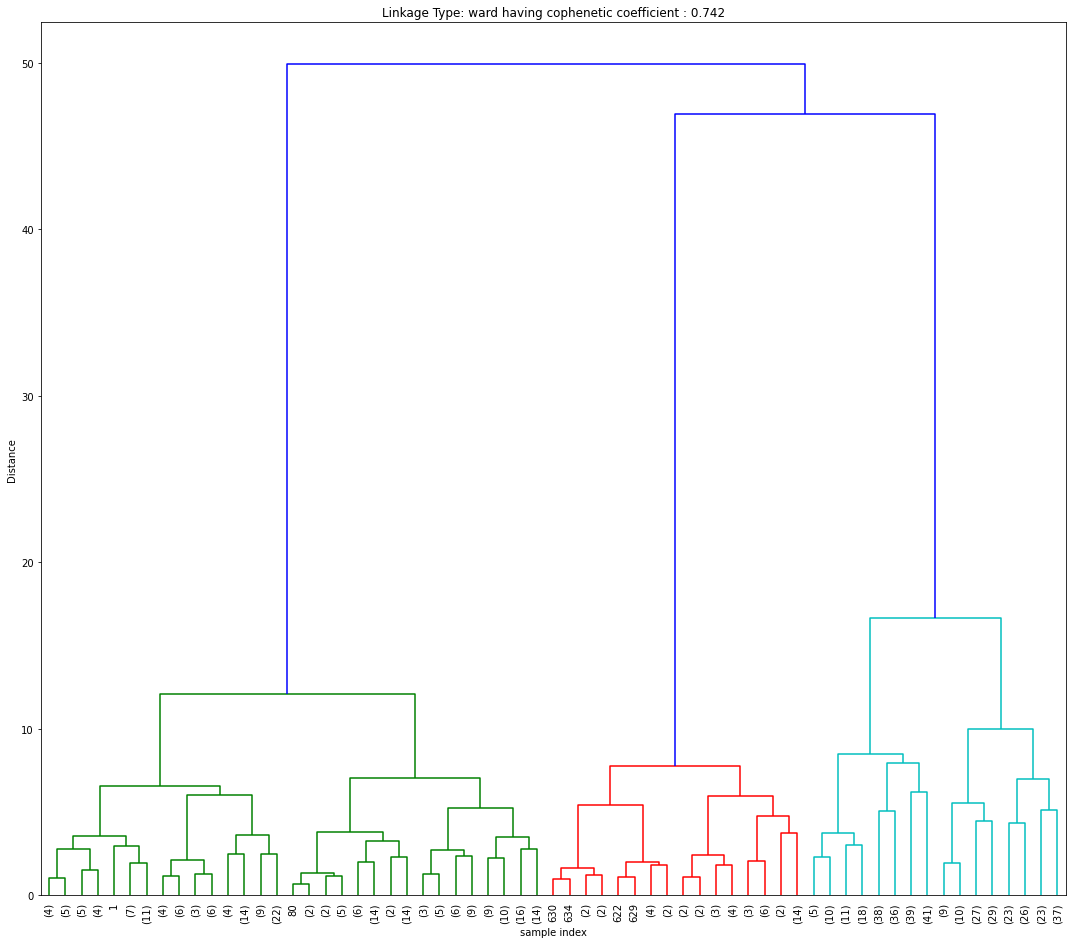

ward 0.7416552814600532


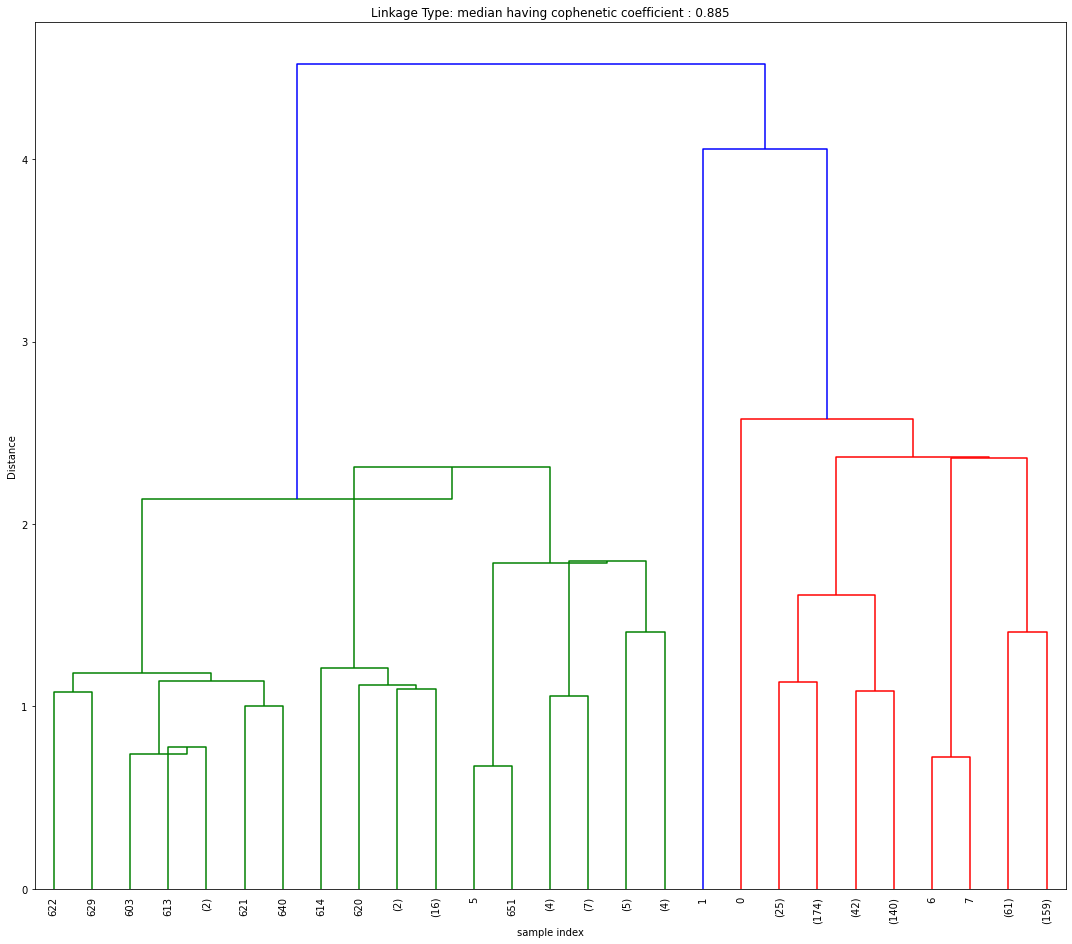

median 0.8845885372905895


In [26]:
linkage_methods=['single','complete','average','ward','median']
results_cophenetic_coef=[]
for i in linkage_methods :
    plt.figure(figsize=(15, 13))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    Z = linkage(subset_scaled_df, i)
    cc,cophn_dist=cophenet(Z,pdist(subset_scaled_df))
    dendrogram(Z,leaf_rotation=90.0,p=5,leaf_font_size=10,truncate_mode='level')
    plt.tight_layout()
    plt.title("Linkage Type: "+ i +" having cophenetic coefficient : "+str(round(cc,3)) )
    plt.show()
    results_cophenetic_coef.append((i,cc))
    print (i,cc)

In [27]:
results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','CopheneticCoefficient'])
results_cophenetic_coef_df

,LinkageMethod,CopheneticCoefficient
0,single,0.739147
1,complete,0.876052
2,average,0.897491
3,ward,0.741655
4,median,0.884589


Looking at the best cophenetic coefficient we get is for "Average" linkage.

But looking at dendogram 'ward' and 'complete' show good difference between clusters.

So choosing 'complete' because it has high cophenetic coefficirnt and good cluster segregation.

Lets make a dendogram for the last 25 formed clusters using complete linkage to have a better view since the above dendograms are very populated 

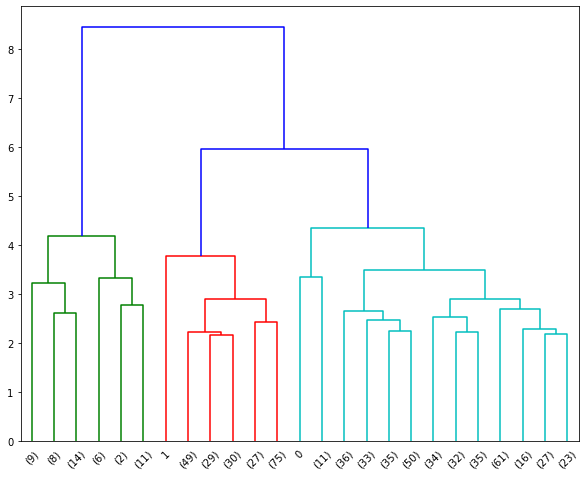

In [28]:
#use truncate_mode='lastp' to select last p formed clusters
plt.figure(figsize=(10,8))
Z = linkage(subset_scaled_df, 'complete', metric='euclidean')

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25 # show only the last p merged clusters
)
plt.show()

Let's take a maximum distance around 5 to form the different clusters as clearly visible it cuts the tallest vertical lines.

In [29]:
max_d=5
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')

In [30]:
set(clusters)  # So there are 3 clusters which are formed 

{1, 2, 3}

### Assign the clusters label to the  data set

In [31]:
dataset2=subset_scaled_df[:] #Create a duplicate of the dataset

In [32]:
dataset2['HierarchicalClusteringLabel']=clusters

In [33]:
dataset2.head(3)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HierarchicalClusteringLabel
0,1.732369,-1.249105,-0.860646,-0.550400,-1.256040,3
1,0.406101,-0.788168,-1.475392,2.510549,1.901468,2
2,0.406101,1.055582,-0.860646,0.129811,0.147297,3


### Analyse the clusters 

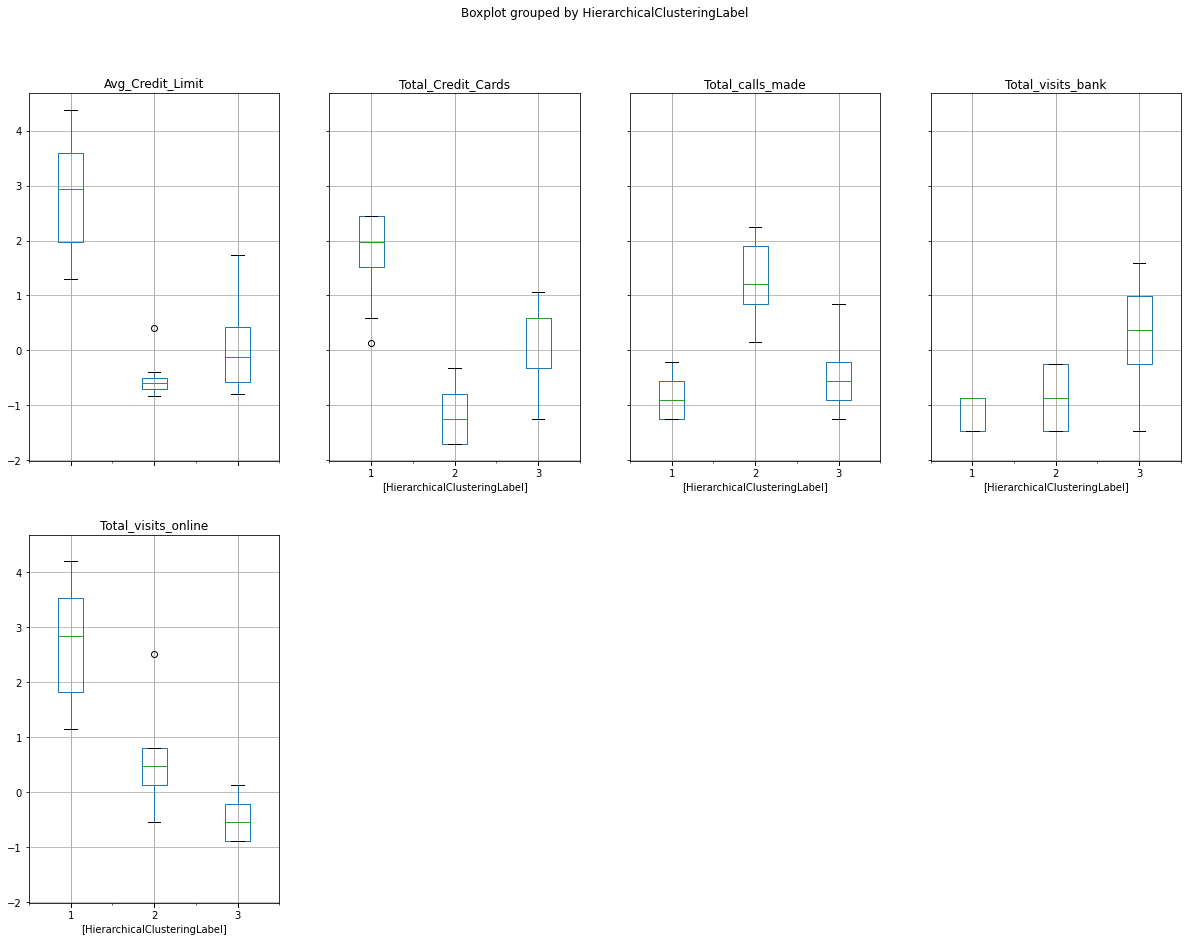

In [34]:
dataset2.boxplot(by = 'HierarchicalClusteringLabel',  layout=(2,4), figsize=(20, 15))
plt.show()

Here also we observe differentiated clusters.

### Silhouette Score

In [35]:
from sklearn.metrics import silhouette_score
silhouette_score(dataset.drop('KmeansLabel',axis=1),dataset['KmeansLabel'])

0.5154656016306806

In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(dataset2.drop('HierarchicalClusteringLabel',axis=1),dataset2['HierarchicalClusteringLabel'])

0.5023200437939186

Silhouette Score is better when closer 1 and worse when closer to -1

Here Kmeans score is slightly better tha Hierarchical

### Comparing Kmeans and Hierarchical Results

In [37]:
Kmeans_results=dataset.groupby('KmeansLabel').mean()
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KmeansLabel,,,,,
0,-0.597083,-1.062239,-0.899413,0.322844,1.147648
1,2.820969,1.857613,-1.106544,2.816644,-0.877139
2,-0.022183,0.373202,0.665788,-0.554840,-0.550708


In [38]:
Hierarchical_results=dataset2.groupby('HierarchicalClusteringLabel').mean()
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HierarchicalClusteringLabel,,,,,
1,2.820969,1.857613,-1.106544,2.816644,-0.877139
2,-0.595451,-1.089634,-0.883954,0.350638,1.196474
3,-0.039107,0.347797,0.613811,-0.545220,-0.529439


#### Carefully observing the above results we can say that : 



Cluster 0 of Kmeans appears similar to Cluster 2 of Hierarchical 


Cluster 1 of Kmeans appears similar to Cluster 3 of Hierarchical 


Cluster 2 of Kmeans appears similar to Cluster 1 of Hierarchical 



#### Let's rename 


Cluster 0 of Kmeans  and Cluster 2 of Hierarchical as G1

Cluster 1 of Kmeans  and Cluster 3 of Hierarchical as G2

Cluster 2 of Kmeans  and Cluster 1 of Hierarchical as G3



In [39]:
Kmeans_results.index=['G1','G2','G3']
Kmeans_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
G1,-0.597083,-1.062239,-0.899413,0.322844,1.147648
G2,2.820969,1.857613,-1.106544,2.816644,-0.877139
G3,-0.022183,0.373202,0.665788,-0.554840,-0.550708


In [40]:
Hierarchical_results.index=['G3','G1','G2']
Hierarchical_results.sort_index(inplace=True)
Hierarchical_results

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
G1,-0.595451,-1.089634,-0.883954,0.350638,1.196474
G2,-0.039107,0.347797,0.613811,-0.545220,-0.529439
G3,2.820969,1.857613,-1.106544,2.816644,-0.877139


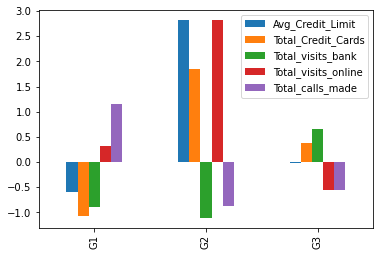

In [41]:
Kmeans_results.plot.bar()

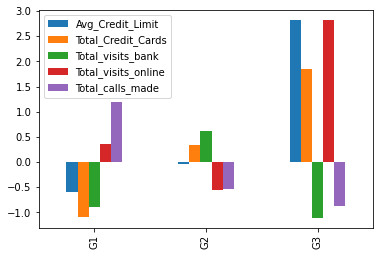

In [42]:
Hierarchical_results.plot.bar()

#### By both the methods of Clustering we get comparable clusters

## Cluster Profiles and Marketing Recommendation

Since both the clustering alogrithms are giving similar clusters so we can assign labels from any one of the algorithm to the original (non scaled) data  to analyse clusters profiles
( here we are assigning labels of Kmeans , same could be done using hierarchical labels) 

In [43]:
subset['KmeansLabel']=dataset['KmeansLabel']


#### Understanding each feature characterstics within different clusters 

In [44]:
for each in cols_to_consider:
    print (each)
    print ( subset.groupby('KmeansLabel').describe().round()[each][['count','mean','min','max']])
    
    print ("\n\n")
    
    

Avg_Credit_Limit
             count      mean      min       max
KmeansLabel                                    
0.0          220.0   12955.0   3000.0  100000.0
1.0           50.0  122980.0  20000.0  200000.0
2.0          380.0   34358.0   5000.0  195000.0



Total_Credit_Cards
             count  mean  min   max
KmeansLabel                        
0.0          220.0   2.0  1.0   6.0
1.0           50.0   8.0  3.0  10.0
2.0          380.0   6.0  1.0  10.0



Total_visits_bank
             count  mean  min  max
KmeansLabel                       
0.0          220.0   1.0  0.0  5.0
1.0           50.0   1.0  0.0  4.0
2.0          380.0   3.0  0.0  5.0



Total_visits_online
             count  mean  min   max
KmeansLabel                        
0.0          220.0   4.0  0.0  12.0
1.0           50.0   9.0  0.0  15.0
2.0          380.0   1.0  0.0  15.0



Total_calls_made
             count  mean  min   max
KmeansLabel                        
0.0          220.0   7.0  1.0  10.0
1.0           

### Analysis of clusters and questions answered :
    

#### 1. How many different segments of customers are there? 

Answer : Total numbers of segments are 3
    
    
  

#### 2. How are these segments different from each other? (Cluster profiles )
  

Answer: 
    

**Label 0 can be considered low valued customers**
   
    This group comprises of about 34% of the customers ( 224/660 )
    
    These customers have a mean "Avg_Credit_Limit " around 12200 and have 2 credit card on an average and the maximum number of credit card as 4.
    
    They are the ones who makes the most number of customer care calls to the bank as the average calls made is 7 



**Label 1 can be considered medium valued customers** 
    
    This group forms the majority of the customers having about 58% customers in total  ( 386/660 )
    
    These customers have  "Avg_Credit_Limit " ranging from 5000.0 to 100000.0 
    
    These are the ones which make the maximum number of visits to the bank as the average visits to bank is 3.
    
    They are the ones who are least active online as the maximum visit onine is just 3



**Label 2 can be considered  high value customers** 
    
    These are the least in number i.e. only 50 customers comprising 7.5% of total customers (50/660) .
    
    These customers have a minimum "Avg_Credit_Limit " of 84000 and have atleast 5 Credit cards .
    
    These are the ones which make the minimum number of visits to the bank as the maximum visit to bank is 1 amongst all 50     customers.
    
    They are mostly using online services as the average visit online is 11. 




#### 3. What are your recommendations to the bank on how to better market to and service these customers? (Business Recommendations )

1. Customers in the medium group ( having Label 1 ) are not engaged much in online activities , one of the exercise can be to engage them online. If they join online , promotions and offers can be communicated to them with much ease.



2. Customers in low group ( label 0 ) can further be binned to check if there are any extreme groups having high average credit limit.These customers can be given more offers and new credit cards so that we can have them in medium group (label 1 )  over a period of time. Similarly we can perform this for medium customers (label 1)  and try to have them in high group (label 2) over a period of time .



3. Customers in low group ( label 0 ) make the most number of customer care calls, these customers can be told about different offers to try and move them to  medium group over a period of time .
